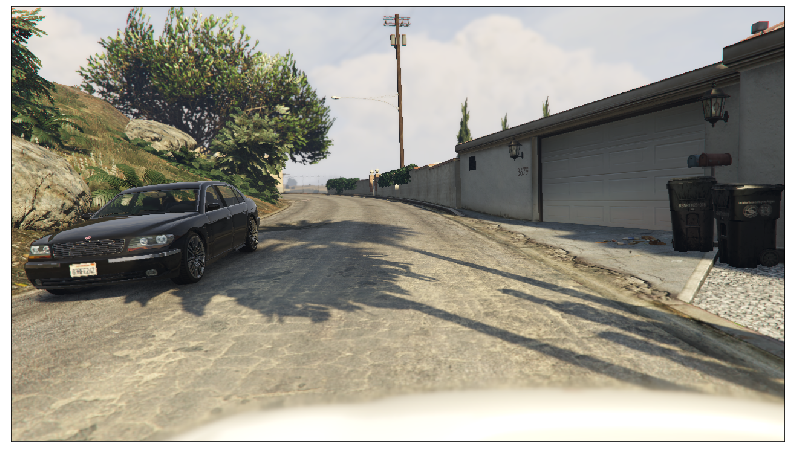

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container{max-width:80%!important;width:auto!important;}</style>"))

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%reload_ext autoreload
%autoreload 2
%matplotlib inline

import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
from functools import partial

from tqdm.notebook import tqdm, trange

import sys
sys.path.append('../')

from depth_Functions import (
    show_img,
    show_array_of_images,
    show_function,
    import_raw_colour_image,
    sum_patch,
    patch_values,
    get_neighbours
)

from Feature_Extraction import (
    create_local_feature_vector,
    titles
)

bgr = import_raw_colour_image('../GTA_images/Simple/Colour/color_1.raw')
show_img(bgr);

from Feature_array import Feature_array

# Creating an array of features

In [3]:
show_function(Feature_array.__init__)

def __init__(self, image, local_function, patch_function=None, patchshapes=[], blur=True, convert=None, dtype = np.float64, show=False, *args, **kwargs):
        if convert is None:
            self.image = image
        else :
            self.image = cv2.cvtColor(image, convert)
        if blur:
            image = cv2.GaussianBlur(image, (5, 5), 0)
        
        self.local_function = local_function
        self.local_features = local_function(image)
        self.shape = self.local_features.shape
        self.patch_function = patch_function

In [4]:
local_features = Feature_array(image=bgr, local_function=create_local_feature_vector,convert=cv2.COLOR_BGR2YCrCb)

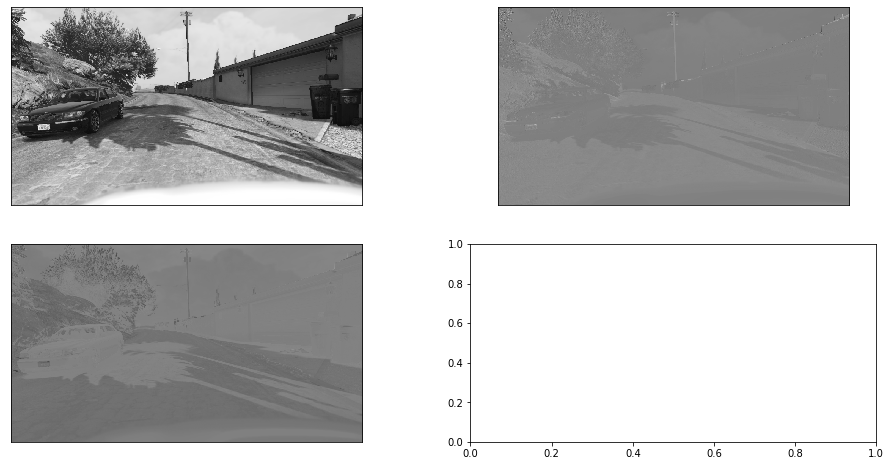

In [5]:
show_array_of_images([local_features.image], split_channels=True, figsize=(8,16))

In [6]:
local_features.local_features.shape

(720, 1280, 17)

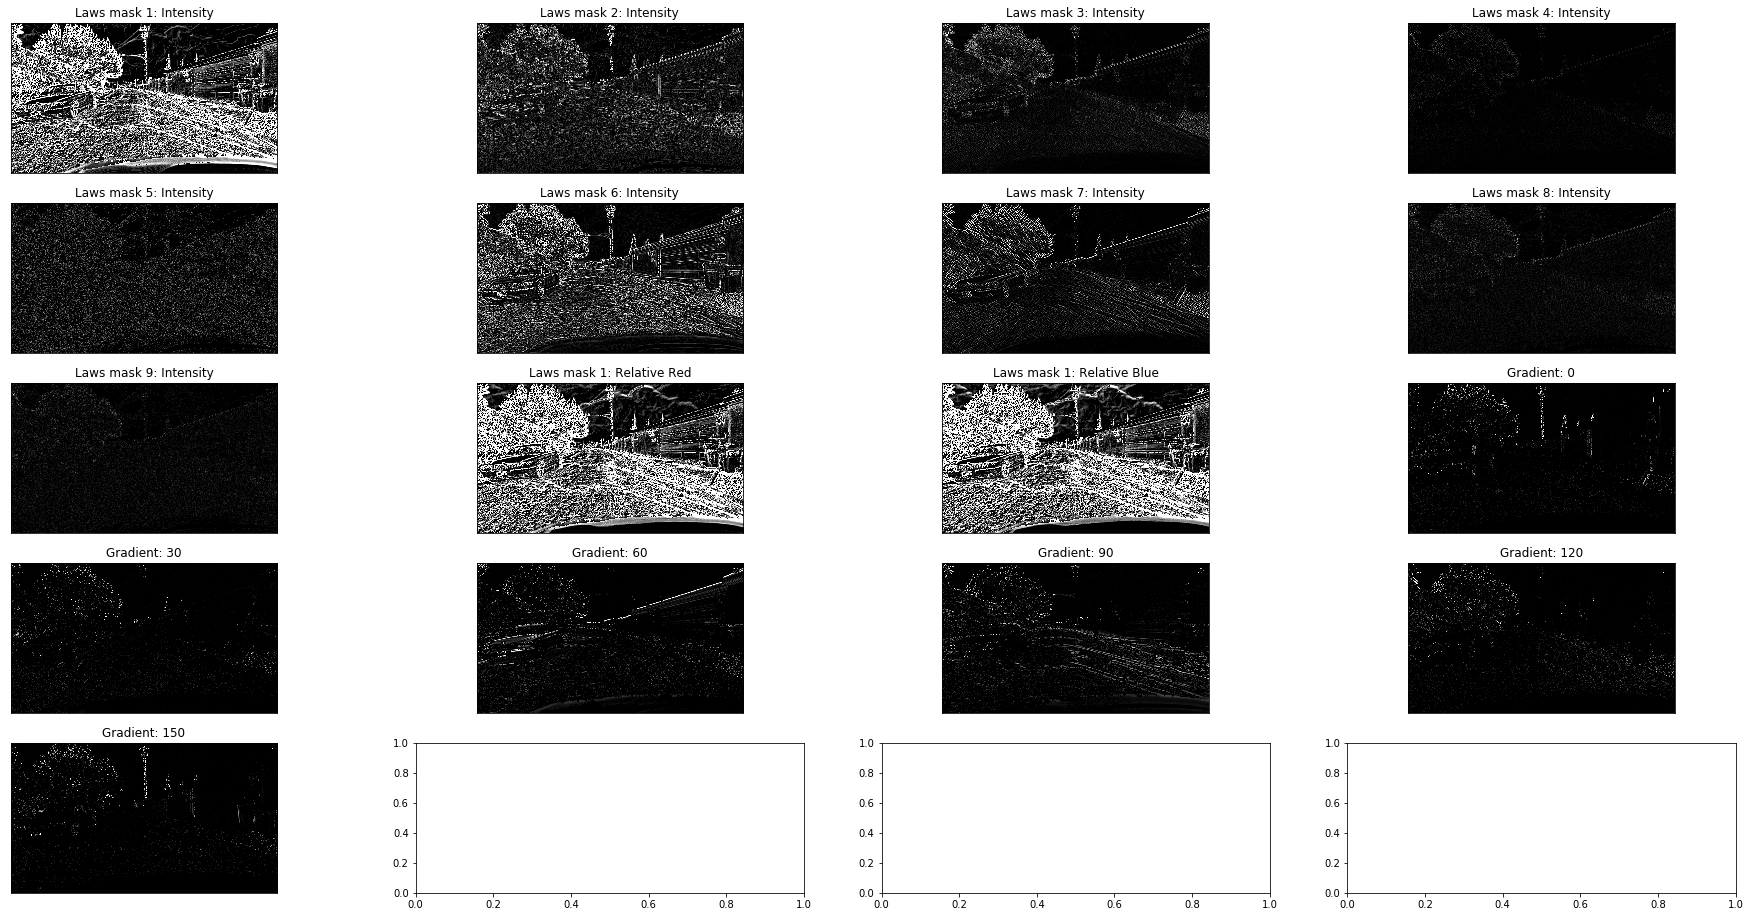

In [7]:
local_features.show_local_features(titles=2*titles)

# Neighbours

In [8]:
show_function(get_neighbours)

def get_neighbours(image, n=1):
    [up, right, down, left] = [image.copy() for i in range(4)]
    up[n:]          = image[:-n]
    right[:,:-n]    = image[:,n:]
    down[:-n]       = image[n:]
    left[:,n:]      = image[:,:-n]    
    return np.stack([image, up, right, down, left], axis=2)

In [9]:
neighbours = get_neighbours(local_features.local_features)

In [11]:
neighbours.shape

(720, 1280, 5, 17)

In [15]:
np.all(neighbours[:,:,0] == local_features.local_features)
np.all(neighbours[0,:,1] == local_features.local_features[0]) and np.all([neighbours[i,:,1] == local_features.local_features[i-1] for i in range(1,neighbours.shape[0])])
np.all(neighbours[:,-1,2] == local_features.local_features[:,-1]) and np.all([neighbours[:,i,2] == local_features.local_features[:,i+1] for i in range(0,neighbours.shape[0]-1)])
np.all(neighbours[-1,:,3] == local_features.local_features[-1]) and np.all([neighbours[i,:,3] == local_features.local_features[i+1] for i in range(0,neighbours.shape[0]-1)])
np.all(neighbours[:,0,4] == local_features.local_features[:,0]) and np.all([neighbours[:,i,4] == local_features.local_features[:,i-1] for i in range(1,neighbours.shape[0])])

True

True

True

True

True

# Patches

We get patch values by applying a filter that replicates the action. In the case below we apply sum by applying a kernel of ones to the desired patchshape

In [22]:
show_function(sum_patch)

def sum_patch(patchshape):
        return np.ones(patchshape)

In [23]:
show_function(patch_values)

def patch_values(image, function, patchshape, stride=None):
    if type(patchshape) == int:
        patchshape = (patchshape, patchshape)
    if stride is None:
        stride = patchshape
    elif type(stride) == int:
        stride = (stride,stride)

    kernel = function(patchshape)

    start = (image.shape[0]%stride[0], image.shape[1]%stride[1])

    heights  = [] if start[0]==0 else [patchshape[0]//2]
    widths   = [] if start[1]==0 else [patchshape[0]//2]
    heights += [y for y in range(start[0]+patchshape[0]//2,image.shape[0],stride[0])]
    widths  += [x for x in range(start[1]+patchshape[1]//2,image.shape[1],stride[1])]

    return cv2.filter2D(image, -1, kernel)[heights][:,widths]

In [24]:
test = patch_values(local_features.local_features, sum_patch, 3)

In [25]:
test.shape

(240, 427, 17)

In [26]:
test[0][-1]

array([-5.87753241, -1.43044278, -4.14144685, -3.2805844 , -0.95665106,
       -5.20817473, -3.43589947, -2.04720887, -3.34675532, -8.77933384,
       -8.88695457, -1.5472989 , -1.79713004, -2.65081767, -2.12324405,
       -1.91043261, -1.5759448 ])

In [27]:
np.all(test[0][0] == np.sum(local_features.local_features[0:3,0:3], axis=(0,1)))
np.all(test[0][1] == np.sum(local_features.local_features[0:3,2:5], axis=(0,1)))
np.all(test[0][-1] == np.sum(local_features.local_features[0:3,-3:], axis=(0,1)))

True

True

True

# Feature iterator

In [16]:
show_function(local_features.feature_iter)

def feature_iter(self, primary, *args, neighbours=True, patchshapes=[], columnshapes=[]):
        features = self.local_features
        columns = [patch_values(features, self.patch_function, ((features.shape[0]//shapes[0]),shapes[1])) for shapes in columnshapes]
        if neighbours:
            features = get_neighbours(features)
        patches = [patch_values(features, self.patch_function, shapes) for shapes in patchshapes]
        features = np.array_split(self.local_features, primary.shape[0])
        # Tracer()()
        features = zip(features,*columns,*[np.array_split(patch, primary.shape[0]) for patch in patches])
        return zip(features, primary, *[arg if arg.shape[0]==primary.shape[0] else np.array_split(arg, primary.shape[0]) for arg in args])

In [17]:
test_weights = np.ones((40,34))
test_labels = np.zeros((720,1280))

In [18]:
local_iter = local_features.feature_iter(test_weights, test_labels, neighbours=False)

In [19]:
iter_list = list(local_iter)
len(iter_list)

40

In [20]:
'features lenght', len(iter_list[0][0])
'features', iter_list[0][0][0].shape
'weights', iter_list[0][1].shape
'labels', iter_list[0][2].shape

('features lenght', 1)

('features', (18, 1280, 17))

('weights', (34,))

('labels', (18, 1280))

In [32]:
global_features = Feature_array(bgr, create_local_feature_vector, patch_function=sum_patch, convert=cv2.COLOR_BGR2YCrCb)

In [34]:
global_iter = global_features.feature_iter(test_weights, test_labels, patchshapes=[(3,3), (9,9)], columnshapes=[(4,3)])

> /storage/depth_estimation/Markov_Random_Field/Feature_array.py(43)feature_iter()
     41             features = get_neighbours(features)
     42         Tracer()()
---> 43         patches = [patch_values(features, self.patch_function, shapes) for shapes in patchshapes]
     44         features = np.array_split(self.local_features, primary.shape[0])
     45         # Tracer()()

ipdb> features.shape
(720, 1280, 5, 17)
ipdb> self.patch_function
<function sum_patch at 0x7f79202d2ef0>
ipdb> shapes
*** NameError: name 'shapes' is not defined
ipdb> patchshapes
[(3, 3), (9, 9)]
ipdb> s
--Call--
> /storage/depth_estimation/Markov_Random_Field/Feature_array.py(43)<listcomp>()
     41             features = get_neighbours(features)
     42         Tracer()()
---> 43         patches = [patch_values(features, self.patch_function, shapes) for shapes in patchshapes]
     44         features = np.array_split(self.local_features, primary.shape[0])
     45         # Tracer()()

ipdb> s
> /storage/dep

ipdb> image.shape
(720, 1280, 5, 17)
ipdb> n
> /storage/depth_estimation/depth_Functions.py(103)patch_values()
    101     if type(patchshape) == int:
    102         patchshape = (patchshape, patchshape)
--> 103     if stride is None:
    104         stride = patchshape
    105     elif type(stride) == int:

ipdb> stride
ipdb> n
> /storage/depth_estimation/depth_Functions.py(104)patch_values()
    102         patchshape = (patchshape, patchshape)
    103     if stride is None:
--> 104         stride = patchshape
    105     elif type(stride) == int:
    106         stride = (stride,stride)

ipdb> n
> /storage/depth_estimation/depth_Functions.py(108)patch_values()
    106         stride = (stride,stride)
    107 
--> 108     kernel = function(patchshape)
    109 
    110     start = (image.shape[0]%stride[0], image.shape[1]%stride[1])

ipdb> n
> /storage/depth_estimation/depth_Functions.py(110)patch_values()
    108     kernel = function(patchshape)
    109 
--> 110     start = (image.

ipdb> n
> /storage/depth_estimation/depth_Functions.py(115)patch_values()
    113     widths   = [] if start[1]==0 else [patchshape[0]//2]
    114     heights += [y for y in range(start[0]+patchshape[0]//2,image.shape[0],stride[0])]
--> 115     widths  += [x for x in range(start[1]+patchshape[1]//2,image.shape[1],stride[1])]
    116 
    117     return cv2.filter2D(image, -1, kernel)[heights][:,widths]

ipdb> n
> /storage/depth_estimation/depth_Functions.py(117)patch_values()
    115     widths  += [x for x in range(start[1]+patchshape[1]//2,image.shape[1],stride[1])]
    116 
--> 117     return cv2.filter2D(image, -1, kernel)[heights][:,widths]
    118 
    119 def get_neighbours(image, n=1):

ipdb> image.shape
(720, 1280, 5, 17)
ipdb> heights
[1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49, 52, 55, 58, 61, 64, 67, 70, 73, 76, 79, 82, 85, 88, 91, 94, 97, 100, 103, 106, 109, 112, 115, 118, 121, 124, 127, 130, 133, 136, 139, 142, 145, 148, 151, 154, 157, 160, 163, 166, 

In [69]:
global_iter_list = list(global_iter)
len(global_iter_list)

40

In [72]:
'features', global_iter_list[0][0][0].shape
'3x3 patches', global_iter_list[0][0][1].shape
'9x9 pacthes', global_iter_list[0][0][2].shape
'weights', global_iter_list[0][1].shape
'labels', global_iter_list[0][2].shape

('features', (18, 1280, 34))

('3x3 patches', (6, 427, 34))

('9x9 pacthes', (2, 143, 34))

('weights', (34,))

('labels', (18, 1280))

(3, 2, 240, 640, 17)